In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

ImportError: cannot import name 'ScikitlearnClassifier' from 'art.estimators.classification' (c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\art\estimators\classification\__init__.py)

In [ ]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("skin", lambda: lru_cache()(skin)())
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
        ("hopskipjump", partial(adversarial, Attack=partial(HopSkipJump, verbose=False), n_instances=10)),
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1
    }
}

In [9]:
reload(librun)

<module 'librun' from 'C:\\Users\\Zac\\Programming\\python\\research\\librun.py'>

In [ ]:
results = librun.run(matrix, workers=3, force_run=True)

Got many warnings:

```
2021-01-08 17:05:26,895 - art.attacks.evasion.hop_skip_jump - WARNING - Failed to draw a random image that is adversarial, attack failed.
```

also warnings about no clip values being specified (deepfool).

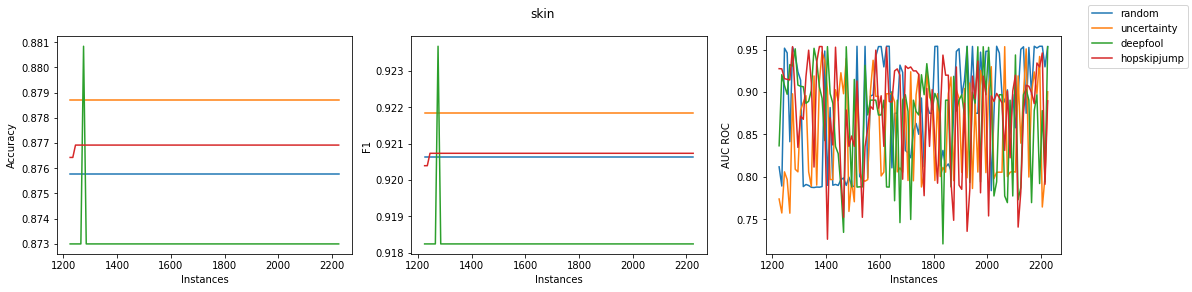

In [4]:
librun.plot(results)

In [12]:
librun.table(results)

skin
╒═════════════╤═══════════╤════════════╤═══════════════╤═══════════╕
│ method      │   AUC LAC │   AUC LF1C │   AUC AUC ROC │ max % @   │
╞═════════════╪═══════════╪════════════╪═══════════════╪═══════════╡
│ uncertainty │    878.71 │     921.85 │        853.64 │ -         │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ hopskipjump │    876.91 │     920.73 │        874.52 │ -         │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ random      │    875.78 │     920.64 │        877.69 │ -         │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ deepfool    │    873.08 │     918.3  │        869.37 │ 1275      │
╘═════════════╧═══════════╧════════════╧═══════════════╧═══════════╛


## Plain SVM trains

In [6]:
from time import monotonic

In [16]:
clf = svm.SVC(kernel='linear')
start = monotonic()
clf.fit(X,y)
print("Time", monotonic()-start)
print("Accuracy", clf.score(X,y))

Accuracy 0.8823049298073784


In [12]:
from thundersvm import SVC as ThunderSVC

In [17]:
clf = ThunderSVC(kernel='linear')
start = monotonic()
clf.fit(X,y)
monotonic()-start

82.34399999999914

In [14]:
clf.score(X,y)

0.8823049298073784